In [69]:
import pandas as pd
import os
import numpy as np
import time as t
import sys
root_path = './'

# 1 邻接表创建

In [2]:
class ArcNode():
  def __init__(self, adj_vex, next_arc, kind, time, money):
    self.adj_vex = adj_vex
    self.next_arc = next_arc
    self.kind = kind
    self.time = time
    self.money = money

class VNode():
  def __init__(self, data):
    self.data = data
    self.first_arc = None

class ALGraph():
    """ 邻接表-图 """
    def __init__(self):
        self.vertices = np.array([], dtype=VNode)
        self.vex_num = 0
        self.arc_num = 0
 
    def locate_vex(self, vertex):
        for i in range(self.vex_num):
            if self.vertices[i].data == vertex:
                return i
        return -1
 
    def create_dg(self, vex_data: list, head_vex: list, tail_vex: list, kind: list, time: list, money:list):
        """
            create directed graph(构建有向图)
            时间复杂度: O( max{n, e} ), n表示顶点数量，e表示弧数量
            vex_data: 所有顶点
            head_vex: 所有弧头
            tail_vex: 所有弧尾
            weight: 所有弧的权值
        """
        self.vex_num = len(vex_data)
        self.arc_num = len(head_vex)
        for i in range(self.vex_num):
            self.vertices = np.append(self.vertices, [VNode(vex_data[i])])
        for i in range(self.arc_num):
            tail_vex_index = self.locate_vex(tail_vex[i])
            head_vex_index = self.locate_vex(head_vex[i])
            first_arc = self.vertices[head_vex_index].first_arc
            arc_node = ArcNode(self.vertices[tail_vex_index].data, first_arc, kind[i], time[i], money[i])
            self.vertices[head_vex_index].first_arc = arc_node

In [3]:
cities = pd.read_csv(os.path.join(root_path, 'cities.csv'), header=None)
cities = cities.reset_index()
cities.columns = ["city_id","country", "city", "latitude", "longitude"]
cities

,city_id,country,city,latitude,longitude
0,0,Afghanistan,Kabul,34.4667,69.18330
1,1,Albania,Tirane,41.3000,19.81670
2,2,Algeria,Algiers,36.7000,3.13333
3,3,American Samoa,Pago Pago,-14.2667,-170.71700
4,4,Andorra,Andorra la Vella,42.5167,1.53333
...,...,...,...,...,...
194,194,Venezuela,Caracas,10.5000,-66.91670
195,195,Vietnam,Hanoi,21.0833,105.91700
196,196,Yugoslavia,Belgrade,44.8333,20.61670
197,197,Zambia,Lusaka,-15.4667,28.26670


In [4]:
#cities_id = dict(zip(cities['city'], cities['city_id']))
cities_id = cities[["city", "city_id"]]
cities_id.head()

,city,city_id
0,Kabul,0
1,Tirane,1
2,Algiers,2
3,Pago Pago,3
4,Andorra la Vella,4


In [5]:
routes = pd.read_csv(os.path.join(root_path, 'routes.csv'), header=None)
routes.dropna(axis=1, how='any', inplace=True)
routes.columns = ['origin', 'destination', 'kind', 'time', 'money']
routes = pd.merge(routes, cities_id, left_on='origin', right_on='city').rename(columns={"city_id":"origin_id"})
routes = pd.merge(routes, cities_id, left_on='destination', right_on='city').rename(columns={"city_id":"destination_id"})
routes.drop(columns=['city_x', 'city_y'], inplace=True)
routes

,origin,destination,kind,time,money,origin_id,destination_id
0,Abu Dhabi,Canberra (Use Sydney),plane,24.00,1339.00,186,10
1,Amsterdam,Canberra (Use Sydney),plane,21.30,804.00,127,10
2,Asmara,Canberra (Use Sydney),plane,44.00,3284.00,60,10
3,Asuncion,Canberra (Use Sydney),plane,57.00,2129.00,141,10
4,Athens,Canberra (Use Sydney),plane,21.83,870.00,75,10
...,...,...,...,...,...,...,...
1970,Tegucigalpa,Managua,plane,4.00,292.00,84,131
1971,Stanley,Stanley,boat,0.00,0.00,63,63
1972,Stanley,Stanley,plane,0.00,0.00,63,63
1973,Tokyo,Saipan,plane,4.00,625.00,95,134


有向图

In [6]:
vex_data = list(cities['city'])
head_vex = list(routes['origin'])
tail_vex = list(routes['destination'])
kind = list(routes['kind'])
time = list(routes['time'])
money = list(routes['money'])

In [7]:
G = ALGraph()
G.create_dg(vex_data, head_vex, tail_vex, kind, time, money)

In [8]:
min = np.inf
p = G.vertices[84].first_arc
while p.next_arc is not None:
  print(p.adj_vex)
  p = p.next_arc
print(p.adj_vex)

Managua
Managua
Managua
San Salvador
San Salvador
Panama
Guatemala
Washington DC
Singapore
Pretoria (Use Johannesburg)
London
Lima
Canberra (Use Sydney)


最优路径分析

In [73]:
def getWeight(G, v0, v, kind):
  min = np.inf
  if v0 == v:
    return 0
  p = G.vertices[v0].first_arc
  while p is not None:
    if G.locate_vex(p.adj_vex) == v:
      if kind == 'time':
        if p.time < min:
          min = p.time
      elif kind == 'money':
        if p.money < min:
          min = p.money
    p = p.next_arc
  return min

def dijkstra(G, origin, kind):
  v0 = G.locate_vex(origin)
  final = list(np.zeros(len(cities_id)))
  path = list(np.zeros(len(cities_id)))
  D = list(np.zeros(len(cities_id)))
  for v in range(G.vex_num):
    final[v] = False
    D[v] = getWeight(G, v0, v, kind)
    path[v] = -1
  D[v0] = 0
  final[v0] = True

  for i in range(G.vex_num - 1):
    min = np.inf
    for w in range(G.vex_num):
      if (final[w] is not True) and (D[w] < min):
        v=w
        min=D[w]
    final[v] = True
    for w in range(G.vex_num):
      if (final[w] is not True) and ((min + getWeight(G, v, w, kind)) < D[w]):
        D[w] = min + getWeight(G, v, w, kind)
        path[w] = v
  return path

In [13]:
path = dijkstra(G, 'Beijing', 'money')
path2 = dijkstra(G, 'Beijing', 'time')

In [11]:
v = 187
best_path = [187]
while path[v] != -1:
  best_path.append(path[v])
  v = path[v]
best_path.append(39)
best_path.reverse()

best_path2 = [187]
while path2[v] != -1:
  best_path2.append(path2[v])
  v = path2[v]
best_path2.append(39)
best_path2.reverse()

for index in best_path2:
  print(G.vertices[index].data)

Beijing
Singapore
Phnom Penh
London


In [20]:
def getCost(G, path, kind):
  cost = 0
  for i in range(len(path)-1):
    origin = path[i]
    destination = path[i+1]
    cost += getWeight(G, origin, destination, kind)
  return cost

#for i in best_path2:
#  print(G.vertices[i].data)
getCost(G, best_path2, 'time')

42.0

# 3 复杂性分析

In [79]:
cities = pd.read_csv(os.path.join(root_path, 'cities.csv'), header=None).sample(20, random_state=123)
cities = cities.reset_index()
cities.columns = ["city_id","country", "city", "latitude", "longitude"]
cities_id = cities[["city", "city_id"]]
routes = pd.read_csv(os.path.join(root_path, 'routes.csv'), header=None)
routes.dropna(axis=1, how='any', inplace=True)
routes.columns = ['origin', 'destination', 'kind', 'time', 'money']
routes = pd.merge(routes, cities_id, left_on='origin', right_on='city').rename(columns={"city_id":"origin_id"})
routes = pd.merge(routes, cities_id, left_on='destination', right_on='city').rename(columns={"city_id":"destination_id"})
routes.drop(columns=['city_x', 'city_y'], inplace=True)
routes

,origin,destination,kind,time,money,origin_id,destination_id
0,Amsterdam,London,plane,1.00000,60.00,127,187
1,Belmopan,London,plane,38.67000,1272.00,19,187
2,Budapest,London,plane,3.00000,250.00,85,187
3,Kigali,London,plane,32.17000,996.00,151,187
4,Phnom Penh,London,plane,30.00000,1486.00,31,187
5,Road Town,London,plane,20.00000,3000.00,26,187
6,San Marino,London,plane,7.00000,600.00,157,187
7,Tokyo,London,plane,26.00000,850.00,95,187
8,Willemstad,London,plane,20.00000,1279.00,128,187
9,Belmopan,Mexico,plane,33.17000,488.00,19,120


In [31]:
vex_data = list(cities['city'])
head_vex = list(routes['origin'])
tail_vex = list(routes['destination'])
kind = list(routes['kind'])
time = list(routes['time'])
money = list(routes['money'])
G = ALGraph()
G.create_dg(vex_data, head_vex, tail_vex, kind, time, money)

In [81]:
x = [16, 32, 64, 128, 199]
y = []
for n in x:
    cities = pd.read_csv(os.path.join(root_path, 'cities.csv'), header=None).sample(n, random_state=123)
    cities = cities.reset_index()
    cities.columns = ["city_id","country", "city", "latitude", "longitude"]
    cities_id = cities[["city", "city_id"]]
    routes = pd.read_csv(os.path.join(root_path, 'routes.csv'), header=None)
    routes.dropna(axis=1, how='any', inplace=True)
    routes.columns = ['origin', 'destination', 'kind', 'time', 'money']
    routes = pd.merge(routes, cities_id, left_on='origin', right_on='city').rename(columns={"city_id":"origin_id"})
    routes = pd.merge(routes, cities_id, left_on='destination', right_on='city').rename(columns={"city_id":"destination_id"})
    routes.drop(columns=['city_x', 'city_y'], inplace=True)
    vex_data = list(cities['city'])
    head_vex = list(routes['origin'])
    tail_vex = list(routes['destination'])
    kind = list(routes['kind'])
    time = list(routes['time'])
    money = list(routes['money'])
    G = ALGraph()
    G.create_dg(vex_data, head_vex, tail_vex, kind, time, money)
    start = t.clock()
    path= dijkstra(G, 187, 'money')
    end = t.clock()
    print('n: ', n, 'num of arc:', len(routes), 'time cost:' , end-start, 's')
    y.append(end-start)


e:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
e:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


n:  16 num of arc: 16 time cost: 0.0023368000001937617 s
n:  32 num of arc: 54 time cost: 0.009726600000249164 s
n:  64 num of arc: 191 time cost: 0.08129590000044118 s
n:  128 num of arc: 948 time cost: 1.2563656000002084 s
n:  199 num of arc: 1975 time cost: 5.499297500000466 s


e:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  # Remove the CWD from sys.path while we load stuff.


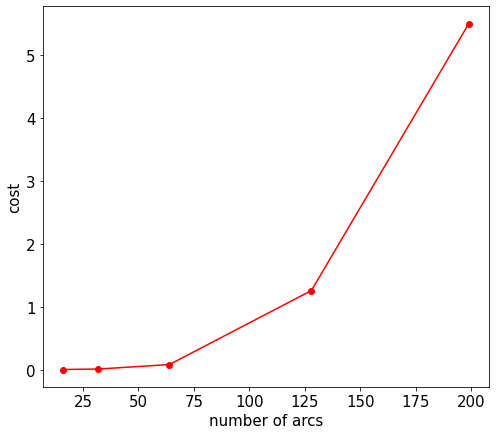

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
plt.plot(x, y, 'r-o')
plt.xlabel('number of arcs', fontsize=15)
plt.ylabel('cost', fontsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
#plt.xscale('log')
plt.savefig('./img.png', bbox='tight', dpi=200)


# 4 可视化

In [ ]:
from ipyleaflet import Map
import folium

map = folium.Map()
for i in range(len(routes)):
  origin_id = routes.iloc[i].origin_id
  destination_id = routes.iloc[i].destination_id
  o_lat = cities.iloc[origin_id].latitude
  o_lon = cities.iloc[origin_id].longitude
  d_lat = cities.iloc[destination_id].latitude
  d_lon = cities.iloc[destination_id].longitude

  folium.PolyLine([[o_lat, o_lon], [d_lat, d_lon]], opacity=0.3, weight=0.5).add_to(map)
map

In [ ]:
map = folium.Map()

lines1 = []
for index in best_path1:
  city = G.vertices[index].data
  lat = cities.iloc[index].latitude
  lon = cities.iloc[index].longitude
  lines1.append([lat, lon])
  folium.Marker([lat, lon], popup=city).add_to(map)
folium.PolyLine(lines1).add_to(map)

lines2 = []
for index in best_path2:
  city = G.vertices[index].data
  lat = cities.iloc[index].latitude
  lon = cities.iloc[index].longitude
  lines2.append([lat, lon])
  folium.Marker([lat, lon], popup=city, color='red').add_to(map)
folium.PolyLine(lines2, color='red').add_to(map)

map